In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import hikinggc
import cartopy
import cartopy.crs as ccrs
import contextily as ctx
import configparser
import logging
import rasterio
import matplotlib.patheffects as path_effects
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LightSource
fa_dir = r"/home/ctroupin/Downloads/fontawesome-free-5.0.13/use-on-desktop/"
fp1 = FontProperties(fname=os.path.join(fa_dir, "Font Awesome 5 Free-Solid-900.otf"))
from importlib import reload
reload(hikinggc)
import matplotlib
matplotlib.style.use("./hiking.mplstyle")

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Let's start")

INFO:root:Let's start


## Files and directories

In [3]:
maketiff = False
gpxdir = "/data/GPX/GCBook/Races/"
basemapdir = "../Data/Basemaps/"
gpxfilelist = sorted(glob.glob(os.path.join(gpxdir, "LaAldea-paralelo28-42km.gpx")))
logger.info(gpxfilelist)
figdir = os.path.join(hikinggc.figdir)

INFO:root:[]


### Configure basemap

In [5]:
apikey = os.environ["THUNDERKEY"]

thunderforest = {
    'url': "https://{s}.tile.thunderforest.com/outdoors/{z}/{x}/{y}.png?apikey=%s" %(apikey),
    'attribution': 'Thunderforest & OpenStreetMap contributors',
    'apikey': apikey,
    'maxZoom': 22
}

cyclosm = {
    'url': 'https://{s}.tile-cyclosm.openstreetmap.fr/cyclosm/{z}/{x}/{y}.png',
    'attribution': 'CyclOSM - Open Bicycle render | Map data: OpenStreetMap contributors',
    'max_zoom': 20,
    'name': 'CyclOSM'
}

OpenStreetMap_Mapnik = {
    'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 
    'maxZoom': 19,
    'attribution': '© OpenStreetMap and contributors'
}

Esri_WorldTopoMap = {
    'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}',
    'attribution': 'Tiles Esri - Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community'   
}

CartoDB_Positron = {
    'url': 'https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png',
    'attribution': '© OpenStreetMap contributors CARTO',
    'maxZoom': 19
}

Stadia_AlidadeSmooth = {
    'url': 'https://tiles.stadiamaps.com/tiles/alidade_smooth/{z}/{x}/{y}{r}.png',
    'maxZoom': 20,
    'attribution': 'Stadia Maps © OpenMapTiles © OpenStreetMap contributors'
    }

CartoDB_DarkMatter = {
    'url': 'https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png',
    'attribution': '© OpenStreetMap contributors © CARTO',
    'subdomains': 'abcd',
    'maxZoom': 19
}

basemapslist = [thunderforest, cyclosm, CartoDB_DarkMatter, CartoDB_Positron, Stadia_AlidadeSmooth,
                Esri_WorldTopoMap, thunderforest]
logger.info(f"Got {len(basemapslist)} basemaps")

INFO:root:Got 7 basemaps


Save basemaps as tiff files

In [5]:
if maketiff is True:
    lonmin, lonmax, latmin, latmax = hikinggc.gccoords
    _ = ctx.bounds2raster(lonmin, latmin, lonmax, latmax,
                     ll=True,
                     path="../Data/Basemaps/Stadia_AlidadeSmooth_12.tiff",
                     source=Stadia_AlidadeSmooth, zoom=12,
                    )

In [6]:
track = hikinggc.Track()
track.get_coords(gpxfilelist[0])

## Loop on tracks

In [7]:
def plot_track_map(trackfile, proj=hikinggc.main_crs, basemapfile=None, figname=None, add_vis=True,
                   trackcolor="#FF8C00"):
    
    track = hikinggc.Track()
    track.get_coords(trackfile)
    
    # Extract bounding box from the GPX track and enlarge the box
    lonmin, lonmax, latmin, latmax = track.enlarge_fig()
    
    logger.info(f"Bounding box: {lonmin}, {lonmax}, {latmin}, {latmax}")
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=proj)

    # Plot the track
    ax.plot(track.lon, track.lat, "--", lw=2, color=trackcolor, transform=hikinggc.data_crs)

    # Add starting point
    ttt = ax.text(track.lon[0], track.lat[0], "\uf3c5", fontproperties=fp1, transform=hikinggc.data_crs,
            fontsize=14, ha="center", va="bottom", color=trackcolor)
    
    ttt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                   path_effects.Normal()])
    
    # Add finish line
    ttt = ax.text(track.lon[-1], track.lat[-1], "\uf11e", fontproperties=fp1, transform=hikinggc.data_crs,
            fontsize=14, ha="left", va="bottom", color=trackcolor)
    
    ttt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                   path_effects.Normal()])

    # Add markers every km
    track.add_km_markers(ax, color=trackcolor)
    
    # ax.set_extent((lonmin, lonmax, latmin, latmax))
    hikinggc.enlarge_fig(ax)

    if add_vis is True:
    
        # Get basemap if needed, save as tiff 
        if basemapfile is None:
            basemapfile = os.path.basename(trackfile).replace(".gpx", ".tiff")
            basemapfile = os.path.join(basemapdir, basemapfile)

            if not os.path.exists(basemapfile):
                logger.info(f"Saving base map as {basemapfile}")
                _ = ctx.bounds2raster(lonmin, latmin, lonmax, latmax,
                         ll=True,
                         path=basemapfile,
                         source=OpenStreetMap_Mapnik,
                         zoom=15,
                        )
            else:
                logger.info("Base map already exists")


        logger.info("Reading basemap from file")

        vis = hikinggc.Visible()
        vis.read_geotiff(basemapfile)

        with rasterio.open(basemapfile) as r:
            bmap = r.read()
            bmap = np.transpose(bmap, [1,2,0])

        ax.imshow(bmap, origin='upper', extent=vis.extent, transform=ccrs.epsg(3857), regrid_shape=5000)


    # Add map scale (length depending on total distance)
    track.compute_dist()
    tracklength = track.dist[-1]
    
    if tracklength < 10.:
        scalelength = 1
    elif tracklength < 50.:
        scalelength = 2
    else:
        scalelength = 10
    
    hikinggc.scale_bar(ax, proj, location=(0.5, 0.05), length=scalelength)
    
    ax.spines['geo'].set_color("w")

    if figname is not None:
         plt.savefig(figname)
    else:
        plt.show()
    plt.close()

In [8]:
for gpxfile in gpxfilelist:
    
    track = hikinggc.Track()
    track.get_coords(gpxfile)
        
    # Create fig
    fname1 = os.path.basename(gpxfile).replace(".gpx", "_cartoDB.png")
    figname1 = os.path.join(figdir, fname1)
    fname2 = "".join(("profile_", os.path.basename(gpxfile).split(".")[0]))
    figname2 = os.path.join(figdir, "profiles/", fname2)
    fname3 = "".join(("minimap_", os.path.basename(gpxfile).split(".")[0]))
    figname3 = os.path.join(figdir, "minimaps/", fname3)
    
    plot_track_map(gpxfile, figname=figname1)
    #track.make_profile(figname2)
    #track.make_minimap(figname3)

INFO:root:Bounding box: -15.8091483, -15.7307427, 27.9179272, 27.9963328
INFO:root:Base map already exists
INFO:root:Reading basemap from file


Domain: [(-1758622.4268113498, -1752382.1789840022), [-1760007.5080471672, -1750997.0977481846], (3219038.403347672, 3228048.8136466546), (3219038.403347672, 3228048.8136466546)


## Camino de Santiago

In [16]:
proj=ccrs.epsg(3857)
basemapfile="../Data/Basemaps/GC_thunderforest.tiff"
    
track2 = hikinggc.Track()
track2.get_coords("../GPX/camino-de-santiago-de-las-palmas-maspalomas-galdar.gpx")
track1 = hikinggc.Track()
track1.get_coords("../GPX/camino-de-santiago-gc.gpx")


lonmin, lonmax, latmin, latmax = track1.enlarge_fig()

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=proj)

ax.plot(track1.lon, track1.lat, "--", lw=2, color="#E2882A", transform=hikinggc.data_crs)
ax.plot(track2.lon, track2.lat, "--", lw=2, color="#E22A2A", transform=hikinggc.data_crs)

ax.text(track1.lon[0], track1.lat[0], "\uf3c5", fontproperties=fp1, transform=hikinggc.data_crs,
        fontsize=16, ha="center", va="bottom", color="#E2882A")

ax.text(track1.lon[-1], track1.lat[-1], "\uf11e", fontproperties=fp1, transform=hikinggc.data_crs,
        fontsize=16, ha="left", va="bottom", color="#E2882A")

#track.add_km_markers(ax)

# Enlarge figure axes
hikinggc.enlarge_fig(ax)

# Get basemap if needed, save as tiff 
if basemapfile is None:
    basemapfile = os.path.basename(trackfile).replace(".gpx", ".tiff")
    basemapfile = os.path.join(basemapdir, basemapfile)

    if not os.path.exists(basemapfile):
        logger.info(f"Saving base map as {basemapfile}")
        _ = ctx.bounds2raster(lonmin, latmin, lonmax, latmax,
                 ll=True,
                 path=basemapfile,
                 source=thunderforest, zoom=12,
                )
    else:
        logger.info("Base map already exists")

logger.info("Reading basemap from file")

vis = hikinggc.Visible()
vis.read_geotiff(basemapfile)

with rasterio.open(basemapfile) as r:
    bmap = r.read()
    bmap = np.transpose(bmap, [1,2,0])

ax.imshow(bmap, origin='upper', extent=vis.extent, transform=ccrs.epsg(3857))

lonmin, lonmax, latmin, latmax = hikinggc.gccoords
ax.set_extent((lonmin, lonmax, latmin, latmax))

# Add map scale
# hikinggc.scale_bar(ax, proj, location=(0.5, 0.05), length=20)

ax.spines['geo'].set_color("w")

plt.savefig(os.path.join(hikinggc.figdir, "santiago_combined4"))
# plt.show()
plt.close()

INFO:root:Reading basemap from file


## All the races together

In [37]:
racedir = "../GPX/Races/"
gpxlist = sorted(glob.glob(os.path.join(racedir, "*.gpx")))
add_vis = False
GC = hikinggc.Island(bbox=hikinggc.gccoords)
GC.get_coastline(hikinggc.GCcoastfile)
munifile = os.path.join(hikinggc.datadir, "municipiosGC.json")
basemapfilegc = os.path.join(basemapdir, "GC_CartoDB_Positron_12.tiff")
topofile = os.path.join(hikinggc.datadir, '136_MDT25_GC/136_MDT25_GC_proj.tif')
topography = hikinggc.Topography()
topography.read_geotiff(topofile)
topography.image = np.ma.masked_less_equal(topography.image, 0.)

In [38]:
#cmap = cmocean.cm.rain_r
# cmap = cmcrameri.cm.oleron
cmap = plt.cm.gray
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(topography.image, cmap=cmap, blend_mode='soft',
               vert_exag=0.05)

# Transform rgb to gray scale, so we can use pcolormesh (imshow failing)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

topogrey = rgb2gray(rgb)
# Mask outside land
topogrey = np.ma.masked_where(topography.image == topography.image.min(), topogrey) 

In [41]:
fig = plt.figure()
ax = plt.axes(projection=GC.proj)

# Loop on the GPX
for gpxfile in gpxlist:
    logger.debug(f"Working on file {gpxfile}")
    racetrack = hikinggc.Track()
    racetrack.get_coords(gpxfile)
        
    ax.plot(racetrack.lon, racetrack.lat, "-", lw=1, transform=hikinggc.data_crs, zorder=5)

shade = ax.pcolormesh(topography.lon, topography.lat, topogrey, cmap=plt.cm.gray,
      transform=hikinggc.data_crs, zorder=3, alpha=1)

vis = hikinggc.Visible()
vis.read_geotiff(basemapfilegc)

with rasterio.open(basemapfilegc) as r:
    bmap = r.read()
    bmap = np.transpose(bmap, [1,2,0])

      

for llon, llat in zip(GC.contour[0], GC.contour[1]):
    ax.plot(llon, llat, linewidth=.5, color="k", transform=hikinggc.data_crs)

# Add municipios
munifile = os.path.join(hikinggc.datadir, "municipiosGC.json")
municipios = hikinggc.Municipios()
municipios.get_from_json(munifile)
municipios.add_to_plot(ax, color=".75", linewidth=.25)

    
    
lonmin, lonmax, latmin, latmax = hikinggc.gccoords
ax.set_extent((lonmin, lonmax, latmin, latmax))

ax.spines['geo'].set_color("w")
#ax.imshow(bmap, origin='upper', extent=vis.extent, transform=ccrs.epsg(3857), zorder=4, 
#          regrid_shape=3500, alpha=.5)

plt.savefig(os.path.join(figdir, "GC_races_03"))
# plt.show()
plt.close()

## TransGranCanaria

In [49]:
gpxdir1 = "../GPX/Races/TGC/"
gpxfilelist1 = sorted(glob.glob(os.path.join(gpxdir1, "TGC-20*.gpx")))
gpxdir2 = "../GPX/"
gpxfilelist2 = sorted(glob.glob(os.path.join(gpxdir2, "UTGC*.gpx")))
gpxfilelist1

['../GPX/Races/TGC/TGC-2009.gpx',
 '../GPX/Races/TGC/TGC-2010.gpx',
 '../GPX/Races/TGC/TGC-2011.gpx',
 '../GPX/Races/TGC/TGC-2012.gpx',
 '../GPX/Races/TGC/TGC-2013.gpx',
 '../GPX/Races/TGC/TGC-2014.gpx',
 '../GPX/Races/TGC/TGC-2015.gpx',
 '../GPX/Races/TGC/TGC-2016.gpx',
 '../GPX/Races/TGC/TGC-2017.gpx',
 '../GPX/Races/TGC/TGC-2018.gpx',
 '../GPX/Races/TGC/TGC-2019.gpx',
 '../GPX/Races/TGC/TGC-2020.gpx',
 '../GPX/Races/TGC/TGC-2021.gpx',
 '../GPX/Races/TGC/TGC-2022.gpx']

In [55]:
cmap = matplotlib.cm.get_cmap('YlOrRd')
ncolors = len(gpxfilelist1)
colorlist = []
for iii in np.linspace(0., 1., ncolors):
    colorlist.append(cmap(iii))
colorlist

[(1.0, 1.0, 0.8, 1.0),
 (1.0, 0.957923875432526, 0.6971472510572857, 1.0),
 (0.999123414071511, 0.9118800461361015, 0.590634371395617, 1.0),
 (0.9966628219915418, 0.8626682045367167, 0.4872895040369089, 1.0),
 (0.996078431372549, 0.7826066897347174, 0.3891118800461361, 1.0),
 (0.9957862360630527, 0.6872279892349097, 0.29336409073433295, 1.0),
 (0.9933256439830834, 0.5961860822760476, 0.25399461745482504, 1.0),
 (0.9909880815071127, 0.4793079584775087, 0.2142560553633218, 1.0),
 (0.9885274894271434, 0.3242906574394464, 0.16996539792387544, 1.0),
 (0.9340253748558247, 0.19312572087658592, 0.13434832756632065, 1.0),
 (0.8679892349096502, 0.0867666282199155, 0.11564782775855437, 1.0),
 (0.774486735870819, 0.022791234140715114, 0.14025374855824682, 1.0),
 (0.6445520953479431, 0.0, 0.14901960784313725, 1.0),
 (0.5019607843137255, 0.0, 0.14901960784313725, 1.0)]

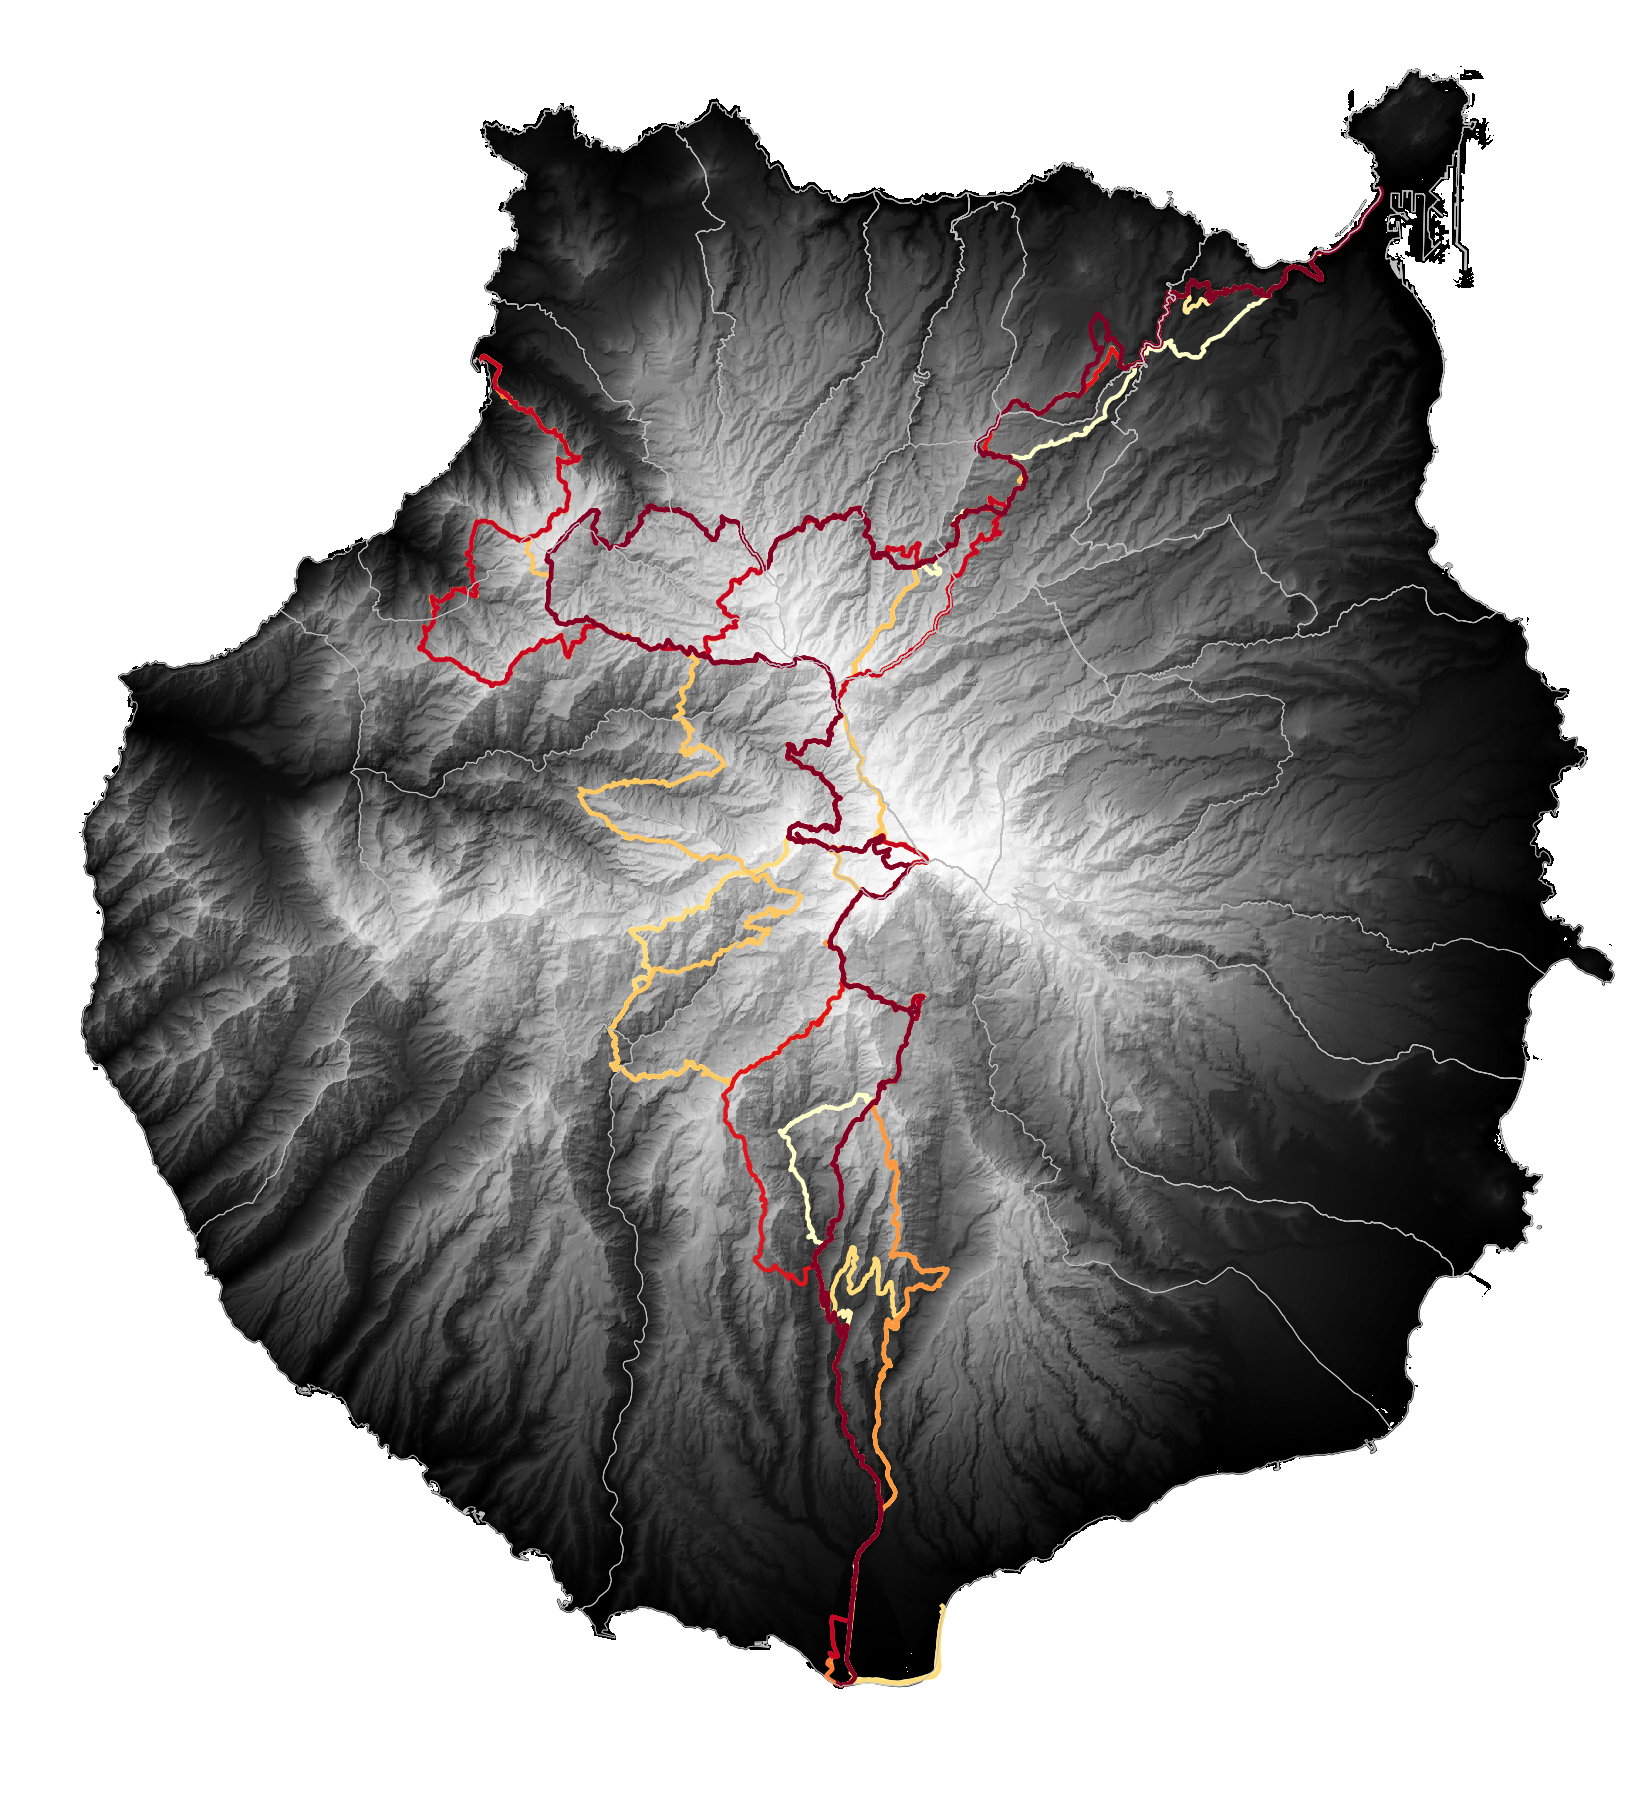

In [56]:
fig = plt.figure()
ax = plt.axes(projection=GC.proj)

# Loop on the GPX
for gpxfile, thecolor in zip(gpxfilelist1, colorlist):
    logger.debug(f"Working on file {gpxfile}")
    racetrack = hikinggc.Track()
    racetrack.get_coords(gpxfile)
        
    ax.plot(racetrack.lon, racetrack.lat, "-", lw=1, color=thecolor, transform=hikinggc.data_crs, zorder=5)

shade = ax.pcolormesh(topography.lon, topography.lat, topogrey, cmap=plt.cm.gray,
      transform=hikinggc.data_crs, zorder=3, alpha=1)

vis = hikinggc.Visible()
vis.read_geotiff(basemapfilegc)

with rasterio.open(basemapfilegc) as r:
    bmap = r.read()
    bmap = np.transpose(bmap, [1,2,0])

      
for llon, llat in zip(GC.contour[0], GC.contour[1]):
    ax.plot(llon, llat, linewidth=.5, color="k", transform=hikinggc.data_crs)

# Add municipios
munifile = os.path.join(hikinggc.datadir, "municipiosGC.json")
municipios = hikinggc.Municipios()
municipios.get_from_json(munifile)
municipios.add_to_plot(ax, color=".75", linewidth=.25, zorder=5)

    
    
lonmin, lonmax, latmin, latmax = hikinggc.gccoords
ax.set_extent((lonmin, lonmax, latmin, latmax))

ax.spines['geo'].set_color("w")
#ax.imshow(bmap, origin='upper', extent=vis.extent, transform=ccrs.epsg(3857), zorder=4, 
#          regrid_shape=3500, alpha=.5)

plt.savefig(os.path.join(figdir, "TGC_tracks_02"))
plt.show()
plt.close()